# Time Series Analysis
## (Plus Lessons Learned about using MultiIndex and DateTime in Pandas)

Anyone with kids will tell you:  kids are unpredictable.  As described in a previous post https://datascienceodyssey.wordpress.com/2016/03/05/data-fitting-and-predictions/, a friend of mine kept track of her infant's eating and sleeping habits, and I wanted to use this data to hopefully shine some light on predictable patterns in the baby's habits over the course of the first year.  My goal with this data set has always been to create a visualization on the evolution of eating and sleeping patterns as the infant ages.

In the course of playing with this data, I decided to incorporate the MultiIndex abilities in pandas to learn about more complex ways of manipulating DataFrames.  (This is also known as hierarchical indexing.  It's creating a hierarchy of column or row labels.)  It's definitely a much more intuitive way (to me) to interpret what data I have, but there are a few little tricks I learned that I wanted to share as I go.  Also, I got much, much more familiar with how pandas, matplotlib, etc. handle datetime objects which smoothed the process considerably.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.nonparametric.smoothers_lowess import lowess
import time
import random

%matplotlib inline

Prior to running this notebook, the raw data needs to be cleaned using:

ipython Pipeline/NursingMunge.py Datafiles/NursingData_6-3.csv

In [2]:
df = pd.read_csv('../Datafiles/NursingData_6-3_clean.csv')

In [3]:
df['time'] = pd.to_datetime(df['time'])

In [4]:
df.head()

,Unnamed: 0,time,Year,Month,TimeofDay,LeftFeed,RightFeed,BotFeed,TotalFeed,BotAmt,Sleep
0,0,2015-06-21 01:17:09,2015,6,Late night,0.00,1.3,0,1.30,NaN,NaN
1,1,2015-06-21 02:00:39,2015,6,Late night,7.52,0.0,0,7.52,NaN,NaN
2,2,2015-06-21 02:37:57,2015,6,Late night,14.50,0.0,0,14.50,NaN,NaN
3,3,2015-06-21 05:23:55,2015,6,Late night,0.00,20.0,0,20.00,NaN,NaN
4,4,2015-06-21 05:47:59,2015,6,Late night,22.18,0.0,0,22.18,NaN,NaN


This is the data as it stands from the last blog post.  For monthly eating and sleeping patterns, there's a lot of info here that we don't need.  In terms of timestamp information, you'll notice that what we have is a start time and an interval of time in decimal form for how long that event lasted.  

# Plotting eat/sleep periods for one day

I want to create a plot going from 0 - 24 hours on the x-axis, with the fraction of the total days that the baby was eating or sleeping at that time.  In order to do that, I need to create a dummy DataFrame with 0 - 24 hours as the rows.  I could have consolidated this into chunks of 30 minutes, 10 minutes, etc. but I decided to go full resolution and calculate it for every minute of the day.  For each event, I need to essentially toggle on each minute if it falls after the start time in the df['time'] column, and is within the interval for how long that event lasted.  To do that, first I create a DataFrame full of 0s, and populate it with 1s where appropriate.

To make sure this is working the way I want, first I did it for a single day, in this case 1/22/2016.

In [5]:
#creating dummy df
date = '1/22/2016'
#for date string listed, parse into dt format 
parsed = dt.datetime.strptime(date,'%m/%d/%Y')
#create date range for index
dateind = pd.date_range(date, periods=1440, freq='min')

ts = pd.DataFrame(np.zeros((len(dateind),2)),columns=['Eat','Sleep'],index=dateind)

Initially, I wanted to read the DataFrame row by row, and then match the year, month, and day in the df.time column with my selected date.  Then I used the later columns in that row to determine whether the event was a feeding or sleep period, and to calculate the end time.

But there's a much better way to do this!  It turns out datetimes can be selected by pretty much any combo of information stored in them.  This can be very specific (i.e. item.year or item.minute) or more general (item.date() or item.time()).  Woohoo!  And also, use enumerate to refer to the rows, duh.  Not sure why I didn't do that the first time.

In [6]:
#cleaner new way to do it
for i,dtinfo in enumerate(df.time):
    if dtinfo.date() == parsed.date():
        eatsleep = ''
        if df.TotalFeed[i] > 0:
            eatsleep = 'e'
            intmin = int(df.TotalFeed[i])#don't care about seconds
            endtime = dtinfo + dt.timedelta(minutes = intmin)
        if df.Sleep[i] > 0:
            eatsleep = 's'
            inthrs = int(df.Sleep[i])
            intmin = int((df.Sleep[i]-inthrs)*60)
            endtime = dtinfo + dt.timedelta(hours = inthrs, minutes = intmin)
        for j,timebymin in enumerate(ts.index):
            if dtinfo.time() < timebymin.time() and timebymin.time() <= endtime.time():
                if eatsleep == 'e':
                    ts.Eat[j] = 1
                if eatsleep == 's':
                    ts.Sleep[j] = 1

So let's see how this looks!  For a single day, the baby slept and ate during the following times:

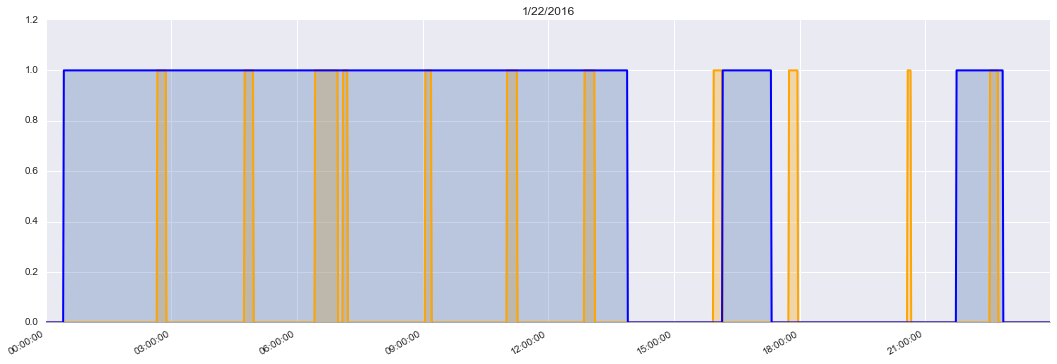

In [7]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
ax.plot(ts.index,ts.Eat,'orange',linewidth=2)
ax.fill_between(ts.index, 0, ts.Eat,alpha=0.3,facecolor='orange')
ax.plot(ts.index,ts.Sleep,'b',linewidth=2)
ax.fill_between(ts.index,0, ts.Sleep,alpha=0.3)
ax.set_ylim(0,1.2)
ax.set_title(date)
fig.autofmt_xdate()
#fig.savefig('Day20160122.png')

In this plot, the sleep periods are in blue, and the eat periods are in orange.  First, this kid slept from around 12:30am - 2:00pm.  A night owl!  Then two naps later in the day, from around 4:30-5:30pm and 9:30-11:00pm.  

The eating schedule is all over the place.  12 different feedings over the course of 24 hours, most during the sleep period.  There is some variation in length, such as the long and short feedings close together just after 6am.  You can see that for that first nap, the baby nursed to sleep since the feeding is immediately before the nap time.  The other thing to notice is the fairly periodic nature of the feedings.  Over "night," they are about 2 hours apart, but they space out a bit more during the awake "daytime" period.

Now, it only took a second to process this data for every minute of the day, so I'll go ahead and proceed at this fine time resolution.  If I wanted to do a more granular dummy DataFrame in order to speed up processing time, I could always resample this to every 5 minutes, every 30 minutes, etc.  Whatever I want.

In [8]:
ts.resample('5min',how='sum',closed='left',label='left')

,Eat,Sleep
2016-01-22 00:00:00,0,0
2016-01-22 00:05:00,0,0
2016-01-22 00:10:00,0,0
2016-01-22 00:15:00,0,0
2016-01-22 00:20:00,0,0
2016-01-22 00:25:00,0,4
2016-01-22 00:30:00,0,5
2016-01-22 00:35:00,0,5
2016-01-22 00:40:00,0,5
2016-01-22 00:45:00,0,5


# Looking at data for all days

## Cleaning the data

I just want to do the exact same process as above, but for all the days in my data set.  Since I won't just have a single day, this is where the MultiIndex will come in handy.  I want both an Eat and a Sleep column for every date.  The code to construct those column titles is shown below.  I appended each date twice to the dateind array (level 0 in the MultiIndex), to account for the fact that each date will have two subcolumns (level 1 in the MultiIndex).  

After creating the dummy DataFrame full of zeroes, I can loop through all the dates to populate it.  Running that loop does take a few minutes, so instead of running that every time I reinitialized the iPython notebook, I saved it as a separate .py file to run from the command line and saved the result, which I read into the notebook whenever I start working again.

You can see the resulting MultiIndex DataFrame below.

In [17]:
#check formatting
tsread = pd.read_csv('../Datafiles/NursingData_5-31_clean_ts.csv', header=[0,1],index_col=[0])
tsread.index = [dt.datetime.strptime(x, "%H:%M:%S").time() for x in tsread.index]
tsread.columns.set_levels([dt.datetime.strptime(x, "%Y-%m-%d").date() for x in tsread.columns.levels[0].values], 0, inplace=True)
tsread.head()

2015-06-21       2015-06-22       2015-06-23       2015-06-24        \
                Eat Sleep        Eat Sleep        Eat Sleep        Eat Sleep   
00:00:00          0     0          1     0          0     0          0     0   
00:01:00          0     0          1     0          0     0          0     0   
00:02:00          0     0          1     0          0     0          0     0   
00:03:00          0     0          1     0          0     0          0     0   
00:04:00          0     0          1     0          0     0          0     0   

         2015-06-25        ...  2016-05-27       2016-05-28       2016-05-29  \
                Eat Sleep  ...         Eat Sleep        Eat Sleep        Eat   
00:00:00          1     0  ...           0     1          1     0          0   
00:01:00          1     0  ...           0     1          1     0          0   
00:02:00          0     0  ...           0     1          1     0          0   
00:03:00          0     0  ...           0     1          1     0          0   
00:04:00          0     0  ...           0     1          1     0          0   

               2016-05-30       2016-05-31        
         Sleep        Eat Sleep        Eat Sleep  
00:00:00     0          1     0          0     1  
00:01:00     0          1     0          0     1  
00:02:00     0          1     0          0     1  
00:03:00     0          1     0          0     1  
00:04:00     0          1     0          0     1  

[5 rows x 692 columns]

Yay!  Now we have our nice MultiIndexed DataFrame.  You notice I had to do a bit of formatting when reading the saved csv back in to make sure that pandas knows those column and row indexes are datetimes, not strings.

## An Aside on MultiIndex

I wanted to back up a bit and explain one of the MultiIndex lessons that I got stuck on in the dummy loop code though.  Notice I have this commented out line at the end of both if loops:

dates is a variable for the particular date that I'm constructing at the moment, and timebymin is the time index we are toggling on.  So for dates = 2016-01-22 and timebymin = 00:04:00, 

<b>ts[dates]</b> will select the 'Eat' and 'Sleep' columns for that date, giving us back the full data for a single day like we had before.  

<b>ts[dates]['Eat']</b> will return just the 'Eat' column for that date.  

<b>ts[dates]['Eat'][timebymin]</b> will return the single value in the 'Eat' column, where the row is 04:00:00.  

So you would think, at least I would, that setting <b>ts[dates]['Eat'][timebymin] = 1</b>would toggle that cell from 0 to 1.  But you (and I) would be wrong, because pandas has some caveats in how it works under the hood.  

It turns out that those additional references in square brackets are interpreted by pandas in the same order shown above (not all at the same time).  First pandas gets the date columns, then the 'Eat' column, then the particular time.  But when it calls those subqueries, sometimes it makes a copy of the columns in question and sometimes it just returns a temporary view of them.  Because of memory allocation that happens behind the scenes, pandas can't predict which case it will be at any given time, so it can't know whether it even has a permanent copy to modify!  Then it throws a <i>SettingWithCopy</i> error, because the cell you want to set may or may not be an editable copy.

Well, we've got to be able to modify our DataFrame, so how do we do it then?  Using the .loc method.

<b>ts.loc[timebymin,(dates,'Eat')]=1</b> tells pandas to find the relevant cell all in one step, and then modify it, so there's no need to return copies/views of columns along the way.  It turns out, in addition to actually reliably working, this is also faster in terms of processing time, so it's really the preferred way to refer to locations in the DataFrame as well.

I highly suggest a thorough read of the docs (http://pandas-docs.github.io/pandas-docs-travis/indexing.html#returning-a-view-versus-a-copy) to learn more details.

## Plotting the data

Now for the best part - turning our hard work into pretty plots!  First, I'm slicing my data into just the eat/sleep data respectively to make it easier to manipulate for plotting.  Then I need to create an x variable for plotting times.  More on that in a sec.

In [18]:
eats= tsread.xs('Eat',level=1,axis=1)
sleeps = tsread.xs('Sleep',level=1,axis=1)

In [22]:
#gets used in the smoothing
timeind = pd.date_range("00:00", "23:59", freq='min').to_pydatetime()###Very important!
xtime = [int(x.hour)+int(x.minute)/60 for x in tsread.index]

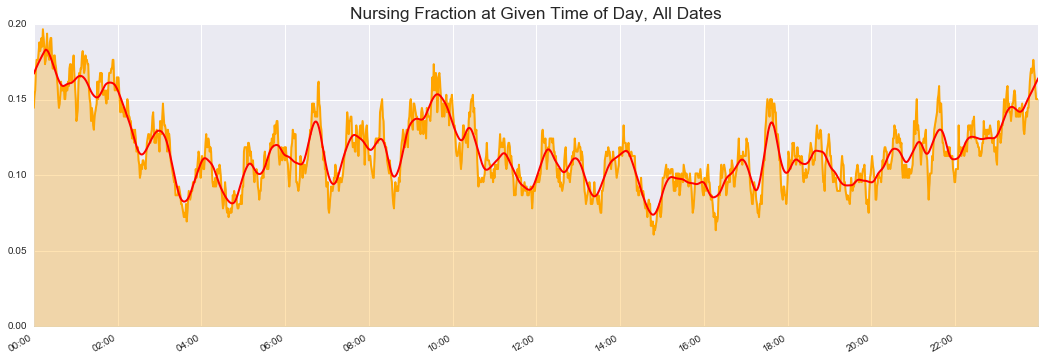

In [20]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)

ax.plot(timeind,eats.sum(axis=1)/len(tsread.columns.levels[0]),'orange',linewidth=2)
ax.fill_between(timeind, 0, eats.sum(axis=1)/len(tsread.columns.levels[0]),alpha=0.3,facecolor='orange')
filtered = lowess(eats.sum(axis=1)/len(tsread.columns.levels[0]), xtime, is_sorted=True, frac=0.025, it=0)
ax.plot(timeind, filtered[:,1], 'r',linewidth=2)

xax = ax.get_xaxis()
xax.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
xax.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('Nursing Fraction at Given Time of Day, All Dates',fontsize='xx-large')
fig.autofmt_xdate()

This plot shows the likelihood over the past year that the baby was eating at any given time of day, calculated by summing all the days with a feeding at that time divided by the total number of days.  The time when you could most likely expect a feeding would be just after midnight, although this is still < 20% of the time.  Honestly, there's not a lot variation in this data (mean = 0.12 +/- 0.02), which means that basically, this kid's eating habits have not been predictable.  There is no particular time of day when feedings tend to happen most often and this baby is obviously not on a feeding schedule.

I went ahead and plotted the raw data in orange, but I wanted to see how much difference smoothing makes, which is shown as the red line.  I like the way it looks, and I don't think I'm losing too much information, so later on, I'll use that more.

## Aside about datetimes

Confession:  I'm a bit of a control freak about my plots.  Now, pandas does a nice job of autoplotting most things, but when I plotted these times, it was breaking the x ticks into annoying 3+ hour chunks because the x axis had to run from 00:00 - 23:59.  It seems like it should be a simple thing to be able to customize your x-axis tickmarks, but it turns out that matplotlib and pandas don't understand each other when talking datetimes.  Normally, if you had data in some format aside from a pandas DataFrame, you can use the .set_major_locator and .set_major_formatter commands to adjust your xaxis using datetimes (see how it uses mdates?).  However, mdates != pandas dates.  Every time I used any kind of customization, my x axis labels would just disappear.  If I left pandas alone and just used .plot(), it was ok, but had the funky tick divisions.

The solution:  that handy line in cell In [22].  Converting the pandas datetimes .to_pydatetime() fixes the issue and then you can use all your matplotlib formatting tricks on your datetimes.  So for any plotting I used the timeind variable rather than tsread.index which, ideally, should have been the same thing.

A friend recently also encountered a similar issue with dates, but she was able to workaround by converting her datetime column from the DataFrame to a list, which she then used as the x variable for plotting.  I haven't tried it but thought I'd share.

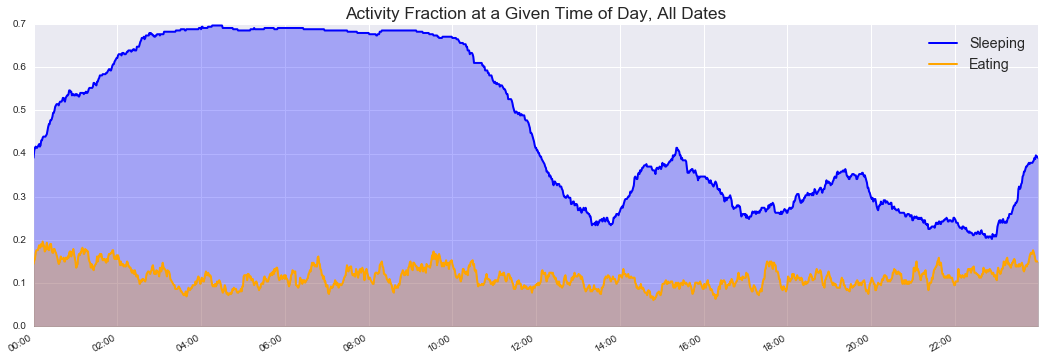

In [21]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)

ax.plot(timeind,sleeps.sum(axis=1)/len(tsread.columns.levels[0]),'b',linewidth=2,label='Sleeping')
ax.fill_between(timeind, 0, sleeps.sum(axis=1)/len(tsread.columns.levels[0]),alpha=0.3,facecolor='b')
ax.plot(timeind,eats.sum(axis=1)/len(tsread.columns.levels[0]),'orange',linewidth=2,label='Eating')
ax.fill_between(timeind, 0, eats.sum(axis=1)/len(tsread.columns.levels[0]),alpha=0.3,facecolor='orange')
#filtered = lowess(sleeps.sum(axis=1)/len(datearr), xtime, is_sorted=True, frac=0.025, it=0)
#ax.plot(ts.index, filtered[:,1], 'r',linewidth=2)
xax = ax.get_xaxis()
xax.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
xax.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('Activity Fraction at a Given Time of Day, All Dates',fontsize='xx-large')
ax.legend(fontsize='x-large')
fig.autofmt_xdate()
#fig.savefig('Activity_All.png')

In this plot, I have exactly the same eating data in orange as before, but with my rescaled y axis, it hangs out near the bottom of the plot.  I have the sleeping data in blue, which (thankfully for the parents) shows much more of a pattern.  70% of the time, this kid was asleep between 3am - 10am.  Note that because the feedings don't drop during that time, it doesn't mean that the parents get an uninterrupted 7 hours of sleep.  Because the likelihood of eating is pretty constant, there's no guarantee what time they'll have to get up to feed the baby.  But this does imply that there are relatively few instances of the baby just being awake for a random hour or two in the middle of the night.

The baby seems to take two naps in the afternoon, somewhere between 2:30-4:30pm and 7-8pm, so there's a bit of predictability, thus improving the parents' sanity.  However, this is aggregated data over the course of the baby's first year.  Babies change a lot that first year, so maybe this is actually not the most useful way to look at the data.  Let's look at month-by-month slices.

In [28]:
monthnum = 1
motxt = time.strftime('%B',time.strptime(str(monthnum),'%m'))
mocheck = [x.month == monthnum for x in tsread.columns.levels[0]]
moflag = []
for ans in mocheck:
    moflag.append(ans)
    moflag.append(ans)

onemo = tsread.loc[:,moflag]
print(len(onemo.columns)/2)

sleepy = onemo.xs('Sleep',level=1,axis=1).sum(axis=1)/(len(onemo.columns)/2)
eaty = onemo.xs('Eat',level=1,axis=1).sum(axis=1)/(len(onemo.columns)/2)

onemo.head()

31.0


2016-01-01       2016-01-02       2016-01-03       2016-01-04        \
                Eat Sleep        Eat Sleep        Eat Sleep        Eat Sleep   
00:00:00          0     0          0     0          0     0          0     1   
00:01:00          0     0          0     0          0     0          0     1   
00:02:00          0     0          0     0          0     0          0     1   
00:03:00          0     0          1     0          0     0          0     1   
00:04:00          0     0          1     0          0     0          0     1   

         2016-01-05        ...  2016-01-27       2016-01-28       2016-01-29  \
                Eat Sleep  ...         Eat Sleep        Eat Sleep        Eat   
00:00:00          0     0  ...           0     0          0     0          0   
00:01:00          0     0  ...           0     0          0     0          0   
00:02:00          0     0  ...           0     0          0     0          0   
00:03:00          0     0  ...           0     0          0     0          0   
00:04:00          0     0  ...           0     0          0     0          0   

               2016-01-30       2016-01-31        
         Sleep        Eat Sleep        Eat Sleep  
00:00:00     0          0     0          0     0  
00:01:00     0          0     0          0     0  
00:02:00     0          0     0          0     0  
00:03:00     0          0     0          0     0  
00:04:00     0          0     0          0     0  

[5 rows x 62 columns]

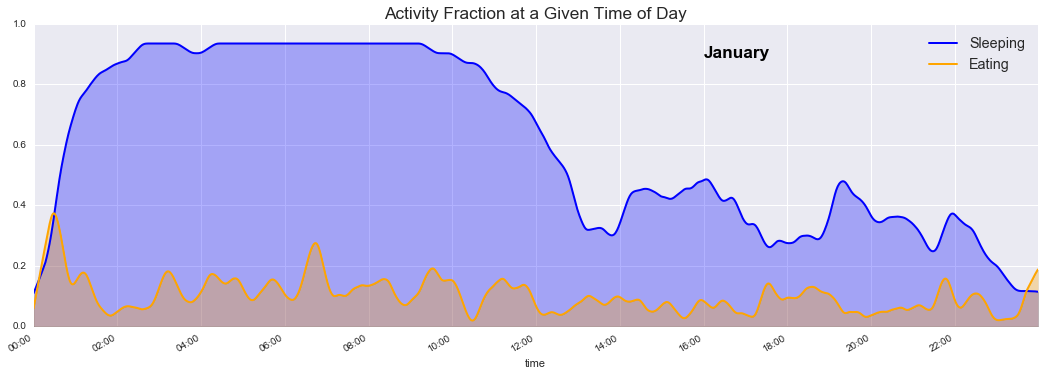

In [29]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)

####Plot Sleep
filtereds = lowess(sleepy, xtime, is_sorted=True, frac=0.025, it=0)
ax.plot(timeind, filtereds[:,1], 'b',linewidth=2,label='Sleeping')
ax.fill_between(timeind, 0, filtereds[:,1],alpha=0.3,facecolor='b')
#ax.plot(ts.index,sleepy,'b',linewidth=2,label='Sleeping')
#ax.fill_between(ts.index, 0, sleepy,alpha=0.3,facecolor='b')

####Plot Eat
filterede = lowess(eaty, xtime, is_sorted=True, frac=0.025, it=0)
ax.plot(timeind, filterede[:,1], 'orange',linewidth=2,label='Eating')
ax.fill_between(timeind, 0, filterede[:,1],alpha=0.3,facecolor='orange')
#ax.plot(ts.index,eaty,'orange',linewidth=2,label='Eating')
#ax.fill_between(ts.index, 0, eaty,alpha=0.3,facecolor='orange')

####Axis formatting
xax = ax.get_xaxis()
xax.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
xax.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('time')
ax.set_title('Activity Fraction at a Given Time of Day',fontsize='xx-large')
ax.text('16:00',max(max(filterede[:,1]),max(filtereds[:,1]))*0.95,motxt,fontsize='xx-large',color='k',fontweight='bold')
ax.legend(fontsize='x-large')
ax.set_ylim(0,1)
fig.autofmt_xdate()
filename = 'Activity_' + str(monthnum) + '.png'
#fig.savefig(filename)

For January, the same month as the single day we plotted at the beginning, bedtime is between 12:00-1:00am, and in fact, the baby seems to have a feeding to fall asleep, denoted by the orange spike coinciding with the sharp increase in the blue line.  Actually, the story here is even better than for all the data, because 90% of the days in January, this baby was asleep from 2:30-9:30am.  

The afternoon is a bit muddled, but it looks like there are two broad nap times.  Keep in mind, the width of the spikes in the afternoon does not tell us the length of the naps.  The first nap time goes from about 2pm-5pm, but the percentage is still < 50%.  So 50% of the time or less, the baby was asleep during that chunk of time.  It's equally likely that that the naps were 1.5 hours and just started at some point in that time frame, or that on some days the baby slept 2+ hours but skipped naps on other days.